# Install necessary functions


In [3]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import load_img, resample_to_img, index_img
from nilearn.masking import intersect_masks, apply_mask, unmask
from nilearn.signal import clean
from nilearn.interfaces.fmriprep import load_confounds
import glob
import re
import matplotlib.pyplot as plt


## Set User Parameters

In [4]:
# -----------------------------------------------------------------------------
# 1) USER PARAMETERS
# -----------------------------------------------------------------------------

# Where your fmriprep lives
base_dir    = '/Volumes/Passport/fmriprep'
task_label  = 'forgot'         # Task label for the fMRI data, e.g., (slumlordreach, pieman, black, forgot, notthefallintact)
stim_label  = 'forgot'       # Shoudl be the same as the task label unless running the reach for the stars (reachforstars) which uses the slumlordreach intersect mask   
output_mask = os.path.join(base_dir,
                           f'group_task-{task_label}_intersect_mask.nii.gz')

# TR indices to keep
tr_slice = slice(3, 163)   # Adjust to match stimulus timing
TR = 1.5

# Exclusions
exclude_subs     = {"sub-139"}        #Example: {'sub-001', 'sub-002'}
exclude_sub_runs = []

# Which BOLD space / resolution to use
preferred_space = 'MNI152NLin2009cAsym'
preferred_res   = 'native'

# *** New: set this if you only want to process one subject ***
# e.g. target_subject = 'sub-002' 
# or target_subject = None  to run on all (minus excluded)
target_subject = None


intersect = load_img(os.path.join(base_dir, 'derivatives',f'{task_label}_masks',f'group_task-{task_label}_intersect_mask.nii.gz'))




In [10]:
EXPECTED_COUNT = {
    "slumlordreach":   17,
    "pieman":          75,
    "black":           46,
    "forgot":          46,
    "reachforstars":   17,
    "notthefallintact":54,
}

ALLOWED_SHAPES = {
    (65, 77, 49, 160),
    (78, 93, 78, 160),
}

## Set subjects list

In [6]:
# -----------------------------------------------------------------------------
# 2) BUILD LIST OF SUBJECTS
# -----------------------------------------------------------------------------
all_subs = sorted(d for d in os.listdir(base_dir)
                  if d.startswith('sub-')
                  and os.path.isdir(os.path.join(base_dir, d)))
if target_subject:
    if target_subject not in all_subs:
        raise ValueError(f"{target_subject} not found under {base_dir}")
    subjects = [target_subject]
else:
    subjects = [s for s in all_subs if s not in exclude_subs]

## Process Bold Run/Clean the timeseries signal

In [11]:
# -----------------------------------------------------------------------------
# 4) PROCESS EACH VALID BOLD RUN (native‑res, already aligned)
# -----------------------------------------------------------------------------
space_res = f"space-{preferred_space}_res-{preferred_res}"

cleaned_count = 0

for sub in subjects:
    func_dir = os.path.join(base_dir, sub, "func")
    # collect preproc BOLD files
    run_pat    = os.path.join(func_dir,
                   f"{sub}_task-{task_label}_run-*_{space_res}_desc-preproc_bold.nii.gz")
    single_pat = os.path.join(func_dir,
                   f"{sub}_task-{task_label}_{space_res}_desc-preproc_bold.nii.gz")
    bold_files = sorted(glob.glob(run_pat)) + sorted(glob.glob(single_pat))
    if not bold_files:
        print(f"Skipping {sub}: no preproc BOLD")
        continue

    for bf in bold_files:
        run_m = re.search(r"_run-(\d+)_", os.path.basename(bf))
        run   = run_m.group(1) if run_m else None
        if run and (sub,run) in exclude_sub_runs:
            print(f"  • skipping {sub} run-{run}")
            continue

        # flexible confounds lookup
        if run:
            conf_pat = os.path.join(func_dir,
                f"{sub}_task-{task_label}_run-{run}_desc-confounds*.tsv")
        else:
            conf_pat = os.path.join(func_dir,
                f"{sub}_task-{task_label}_desc-confounds*.tsv")

        confs = sorted(glob.glob(conf_pat))

        # Assert we have confounds for each file
        assert confs, f"[{os.path.basename(bf)}] Missing confounds (checked {conf_pat})"


        conf_file = confs[0]

        print(f"\nProcessing {sub}{'_run-'+run if run else ''}: {os.path.basename(bf)}")
        bold_img = load_img(bf)

        # ── SANITY CHECK alignment ─────────────────────────────────────────────
        # Make sure shapes and affines exactly match the intersect mask; otherwise skip.
        assert bold_img.shape[:3] == intersect.shape, \
               f"[{sub}{run}] shape mismatch: bold {bold_img.shape[:3]} vs mask {intersect.shape}"
        assert np.allclose(bold_img.affine, intersect.affine), \
               f"[{sub}{run}] affine mismatch between bold and mask"

        # ─────────────────────────────────────────────────────────────────────────



        # -----------------------------------------------------------------------------
        # LOAD CONFOUNDS via nilearn’s fmriprep interface
        # -----------------------------------------------------------------------------
        print("Loading confounds…")
        confounds_df, sample_mask = load_confounds(
        img_files    = bf,
        strategy     = ('motion', 'high_pass', 'wm_csf'),
        motion       = 'full',
        wm_csf       = 'basic',
        global_signal= 'basic',
        compcor      = 'anat_combined',
        n_compcor    = 'all',
        ica_aroma    = 'full',
        scrub        = 5,
        fd_threshold = 0.2,
        std_dvars_threshold = 3,
        demean       = True
        )

        
        #   clean up infinities / NaNs
        # confounds_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        # confounds_df.fillna(0, inplace=True)


        # extract TR and mask‐then‐clean
        tr = float(bold_img.header.get_zooms()[3])
        ts = apply_mask(bold_img, intersect)
        assert tr in (1500,1.5), f"TR mismatch: {tr} vs 1500"
        print("shape of time series:", ts.shape)
        # assert ts.shape == (300,43981), f'unexpected shape {ts.shape} should be (300,43981)' 


        # full‐length clean with every kwarg spelled out
        ts_clean = clean(
        signals         = ts,
        runs            = None,
        detrend         = True,
        standardize     = 'zscore_sample',    # use sample‐std zscore
        sample_mask     = None,
        confounds       = confounds_df,
        standardize_confounds = 'zscore_sample',
        low_pass        = 0.1,
        high_pass       = 0.01,
        t_r             = TR,
        ensure_finite   = True,
        )

        # back to 4D NIfTI
        cleaned_img = unmask(ts_clean, intersect)

        # now select only our TR window via index_img
        sel_img = index_img(cleaned_img, tr_slice)

        # --- ADD THIS LINE to fix TR in the header ---
        sel_img.header.set_zooms(sel_img.header.get_zooms()[:3] + (TR,))

        # sanity check: should be 160 TRs
        assert sel_img.shape in ALLOWED_SHAPES, (
            f"unexpected shape {sel_img.shape}, "
            f"must be one of {ALLOWED_SHAPES}"
        )
        assert sel_img.shape[-1] == 160 , f'unexpected TR length {sel_img.shape} should be 160 TRs long' 

        # save into derivatives/{task_label}_cleaned
        run_tag   = f"_run-{run}" if run else ""
        deriv_dir = os.path.join(base_dir, "derivatives", f"{stim_label}_cleaned")
        out_dir   = os.path.join(deriv_dir, sub, "func")
        os.makedirs(out_dir, exist_ok=True)

        out_file = os.path.join(out_dir,
                     f"{sub}_task-{stim_label}{run_tag}_cleaned_desc-masked_bold.nii.gz")
        sel_img.to_filename(out_file)
        print("  → saved to:", out_file)
        
        
        cleaned_count += 1

print("\nALL DONE.")


# look up the expected count for this stimulus
expected = EXPECTED_COUNT.get(stim_label)
assert expected is not None, f"❌ No expected count defined for stim '{stim_label}'"
# now assert dynamically
assert cleaned_count == expected, (
    f"❌ Expected to clean {expected} files for stim '{stim_label}', "
    f"but cleaned {cleaned_count}."
)
print(f"✅ Successfully cleaned {cleaned_count} files.")

Skipping sub-001: no preproc BOLD
Skipping sub-002: no preproc BOLD
Skipping sub-003: no preproc BOLD
Skipping sub-004: no preproc BOLD
Skipping sub-005: no preproc BOLD
Skipping sub-006: no preproc BOLD
Skipping sub-007: no preproc BOLD
Skipping sub-008: no preproc BOLD
Skipping sub-009: no preproc BOLD
Skipping sub-010: no preproc BOLD
Skipping sub-011: no preproc BOLD
Skipping sub-012: no preproc BOLD
Skipping sub-013: no preproc BOLD
Skipping sub-014: no preproc BOLD
Skipping sub-015: no preproc BOLD
Skipping sub-016: no preproc BOLD
Skipping sub-017: no preproc BOLD
Skipping sub-018: no preproc BOLD
Skipping sub-019: no preproc BOLD
Skipping sub-020: no preproc BOLD
Skipping sub-021: no preproc BOLD
Skipping sub-022: no preproc BOLD
Skipping sub-023: no preproc BOLD
Skipping sub-024: no preproc BOLD
Skipping sub-025: no preproc BOLD
Skipping sub-026: no preproc BOLD
Skipping sub-027: no preproc BOLD
Skipping sub-028: no preproc BOLD
Skipping sub-029: no preproc BOLD
Skipping sub-0

KeyboardInterrupt: 

## Optional Visualize and Voxel Count for sanity check 

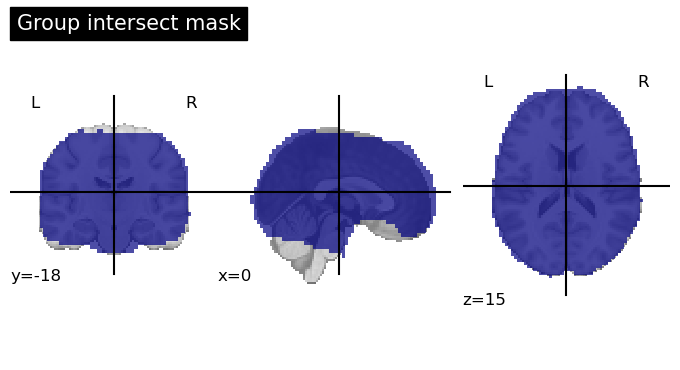

In [ ]:
from nilearn.plotting import plot_roi
plot_roi(intersect, title='Group intersect mask')

In [ ]:
import numpy as np
import nibabel as nib
grp = intersect.get_fdata().astype(bool)
print("Group mask voxels:", grp.sum())

Group mask voxels: 49184


## Pre-clean vs. Post-clean voxel timeseries

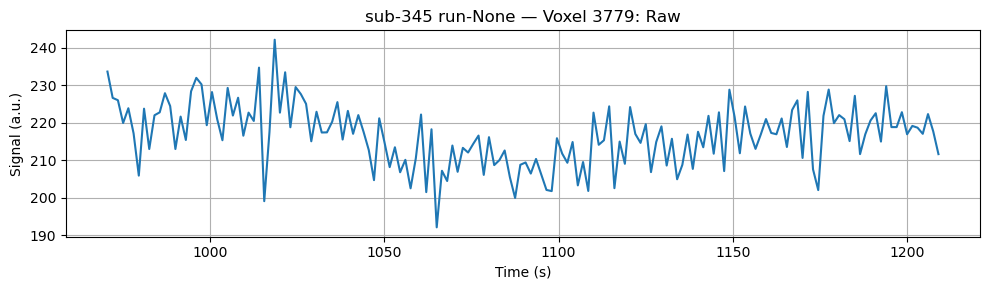

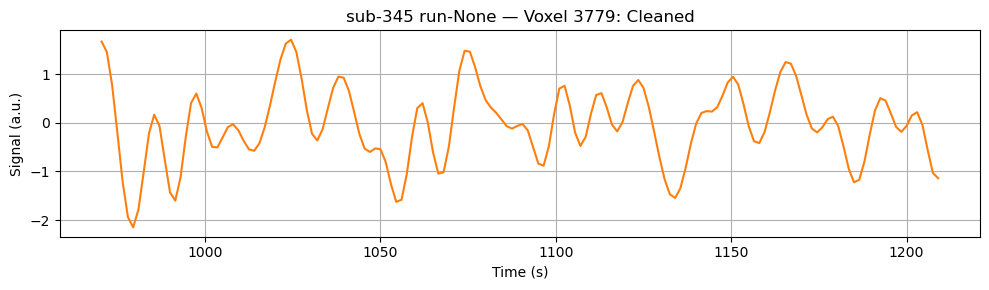

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# 1) extract just the window you processed
X_raw = ts[tr_slice, :]       # (n_TRs_sub, n_voxels)
X_cln = ts_clean[tr_slice, :] # same shape

n_TRs_sub, n_vox = X_raw.shape

# 2) build a time axis in seconds
time_axis = np.arange(n_TRs_sub) * TR + (tr_slice.start * TR)

# 3) choose a single voxel (random or fixed)
v_idx = np.random.randint(n_vox)   # or set v_idx = 42

# 4) Plot raw on its own figure
plt.figure(figsize=(10, 3))
plt.plot(time_axis, X_raw[:, v_idx], color='tab:blue')
plt.title(f"{sub} run-{run} — Voxel {v_idx}: Raw")
plt.xlabel("Time (s)")
plt.ylabel("Signal (a.u.)")
plt.grid(True)
plt.tight_layout()

# 5) Plot cleaned on its own figure
plt.figure(figsize=(10, 3))
plt.plot(time_axis, X_cln[:, v_idx], color='tab:orange')
plt.title(f"{sub} run-{run} — Voxel {v_idx}: Cleaned")
plt.xlabel("Time (s)")
plt.ylabel("Signal (a.u.)")
plt.grid(True)
plt.tight_layout()

plt.show()